# Table of contents:
- **[Step 1]()**: Setting up TensorFlow and Colab Runtime
- **[Step 2]()**: Installing tensorflow Model garden pakage and other required dependencies 
- **[Step 3]()**: Importing libraires and data loading
- **[Step 4]()**: Splitting the data
- **[Step 5]()**: Defining a tensorflow model for text preprocessing as per BERT requirements . 
- **[Step 6]()**: Creating a Tensorflow input pipeline using `tf.data` API
- **[Step 7]()**: Functions for applying the preprocessing model on entire dataset using `.map` method  
- **[Step 8]()**: Creating input preprocessed input pipelines for both Train and Val sets 
- **[Step 9]()**: Adding a Classification Head to the BERT `hub.KerasLayer` 
- **[Step 10]()**: Fine-Tuning BERT for sentence pairs Classification 
- **[Step 11]()**: Evaluating Model performance visually
- **[Step 12]()**: Exporting Model for Inference
- **[Step 13]()**: Testing our BERT Model

### Step 1: Setting up TensorFlow and Colab Runtime

In [ ]:
# Configuration for GPU in order to avoid some errors when fitting the data
import tensorflow as tf
configuration = tf.compat.v1.ConfigProto()
configuration.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=configuration)


In [ ]:
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")
!nvidia-smi

GPU is available
Tue Jul  6 05:23:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    32W /  70W |    222MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                       

### Step 3: Installing tensorflow Model garden pakage and other required dependencies 

In [ ]:
pip install -q -U tensorflow-text


In [ ]:
!pip install -q tf-models-official


In [ ]:
pip install -U tfds-nightly


Requirement already up-to-date: tfds-nightly in /usr/local/lib/python3.7/dist-packages (4.3.0.dev202107050107)


### Step 3: Importing libraires and data loading 

In [ ]:
import datetime
import pickle
import pandas as pd

pd.set_option("max_columns",100)
pd.set_option('display.width',1000)
pd.set_option('max_colwidth', 1000) 
import warnings 
warnings.filterwarnings('ignore')
import os

import numpy as np
import matplotlib.pyplot as plt


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Loading the required submodules
import official.nlp.optimization
from official.nlp import optimization  # to create AdamW optimizer
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
from official.nlp.bert import tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks
tf.get_logger().setLevel('ERROR')


In [ ]:
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("Tensorflow version: ", tf.version.VERSION)

Eager mode:  True
Hub version:  0.12.0
Tensorflow version:  2.5.0


In [ ]:
from google.colab import drive
drive.mount('gdrive')

Mounted at gdrive


In [ ]:
%cd /content/gdrive/MyDrive/Colab DataSets/

/content/gdrive/MyDrive/Colab DataSets


In [ ]:
pip install pickle5

     |████████████████████████████████| 133kB 33.4MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp37-cp37m-linux_x86_64.whl size=219253 sha256=3477c06237eb4b612a7a8da3a712ffb75b340cdd010fa8ea88e60e317d8b915a
  Stored in directory: /root/.cache/pip/wheels/a6/90/95/f889ca4aa8b0e0c7f21c8470b6f5d6032f0390a3a141a9a3bd
Successfully built pickle5


In [ ]:
import pickle5

config = pickle5.load(open(f"/content/gdrive/MyDrive/Colab DataSets/clean_data.pkl", "rb"))
print(type(config))

df = config.copy(deep = True)
del(config)
df.drop(columns= 'Lead Name' , inplace=True)
df.drop(columns= 'Location' , inplace=True)
df.drop(columns= 'Status information' , inplace=True)
df.head()

<class 'pandas.core.frame.DataFrame'>


,Status,Clean_text
0,0,prema share I detail available eng prema postpone plan train currently prema not interested now
1,0,prema cal I try share detail email prema share detail email will check i revert prema receive email I look as certification
2,1,aug mohan rne
3,0,surendra I want server aug mohan cal busy aug mohan reg server
4,0,prema rne prema give info he say he will revert he prema plan next month share detail


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 956 entries, 0 to 1000
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Status      956 non-null    int64 
 1   Clean_text  956 non-null    object
dtypes: int64(1), object(1)
memory usage: 22.4+ KB


In [ ]:
df['Status '].value_counts() 

0    829
1    127
Name: Status , dtype: int64

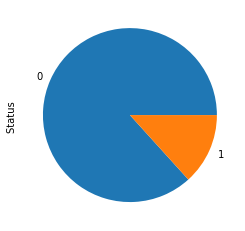

In [ ]:
df['Status '].value_counts().plot(kind='pie')

### Step 4: Splitting the data

In [ ]:
from sklearn.model_selection import train_test_split

train_df , test_df = train_test_split(df, random_state = 42 , train_size = 0.9 , stratify = df['Status '].values )

train_df.shape , test_df.shape

((860, 2), (96, 2))

In [ ]:
print("Train data distribution : ", train_df['Status '].value_counts().tolist(),"\n")
print("Test data distribution : ", test_df['Status '].value_counts().tolist())

Train data distribution :  [746, 114] 

Test data distribution :  [83, 13]


In [ ]:
train_size = train_df.shape[0]
test_size = test_df.shape[0]

print(train_size, test_size)

860 96


In [ ]:
# Cheking the max/min/average source sequence length
source_length_list=[]
for source in df['Clean_text']:
  source_length_list.append(len(source.split(' ')))
max_seq_length = max(source_length_list)
min_seq_length = min(source_length_list)
avg_seq_lenght = np.average(source_length_list)
print(" Maximum source length " , max_seq_length)
print(" Minimum source length " , min_seq_length)
print(" Average source length " , avg_seq_lenght)

 Maximum source length  98
 Minimum source length  2
 Average source length  18.074267782426777


### Step 5: Defining a tensorflow model for text preprocessing as per BERT requirements . 

In [ ]:
def make_bert_preprocess_model(sentence_feature):
  """Returns Model mapping string features to BERT inputs.

  Args:
    sentence_feature: a list with the name of string-valued feature.
    seq_length: an integer that defines the sequence length of BERT inputs.

  Returns:
    A Keras Model that can be called on a list of string Tensor
    (with the order or name, resp., given by sentence_feature) and
    returns a dict of tensors for input to BERT.
  """

  
  input_segment = tf.keras.layers.Input(shape=(), dtype=tf.string , name = sentence_feature)

  preprocessor = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
  
  # Tokenizing raw text to BERT input features.
  bert_preprocess = hub.load(preprocessor)
  preprocessor = hub.KerasLayer(bert_preprocess, name='tokenizer')
  encoder_inputs = preprocessor(input_segment)
  
  return tf.keras.Model(input_segment, encoder_inputs)


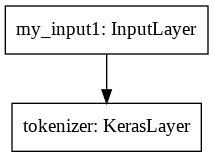

In [ ]:
test_preprocess_model = make_bert_preprocess_model(str('my_input1'))
tf.keras.utils.plot_model(test_preprocess_model)


In [ ]:
test_text = [np.array(['Range Rover is my favourite car'])]
text_preprocessed = test_preprocess_model(test_text)

print('Type of output : ', type(text_preprocessed))
print('Keys           : ', list(text_preprocessed.keys()))
print('Shape Word Ids : ', text_preprocessed['input_word_ids'].shape)
print('Word Ids       : ', text_preprocessed['input_word_ids'][0, :16])
print('Shape Mask     : ', text_preprocessed['input_mask'].shape)
print('Input Mask     : ', text_preprocessed['input_mask'][0, :16])
print('Shape Type Ids : ', text_preprocessed['input_type_ids'].shape)
print('Type Ids       : ', text_preprocessed['input_type_ids'][0, :16])

Type of output :  <class 'dict'>
Keys           :  ['input_word_ids', 'input_mask', 'input_type_ids']
Shape Word Ids :  (1, 128)
Word Ids       :  tf.Tensor(
[  101  2846 13631  2003  2026  8837  2482   102     0     0     0     0
     0     0     0     0], shape=(16,), dtype=int32)
Shape Mask     :  (1, 128)
Input Mask     :  tf.Tensor([1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0], shape=(16,), dtype=int32)
Shape Type Ids :  (1, 128)
Type Ids       :  tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(16,), dtype=int32)


### Step 6: Creating a Tensorflow input pipeline using `tf.data` API

In [ ]:
# Creating input pipeline on CPU to use GPU efficiently 

with tf.device('/cpu:0'):
  
  train_data = tf.data.Dataset.from_tensor_slices((train_df['Clean_text'].values, train_df['Status '].values ))
  test_data = tf.data.Dataset.from_tensor_slices((test_df['Clean_text'],  test_df['Status '].values ))

  for text, label in train_data.take(1):
    print(text)
    print(label)

tf.Tensor(b'may mohan mail send', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


### Step 7: Functions for applying the preprocessing model on entire dataset using `.map` method . 

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

""" Here we will pass each inidividual Dataset like train_data, test_data to function "load_dataset"
    that applies the above TF preprocessing model on the provided inputs by further applying a wrapper function (bert_preprocess_model) and 
    returns the Data ready for BERT input """
     

def bert_preprocess_model(text , label):
  """
  Wrapper function
  """
  # Initializing Preprocessing model to only accept text field as inputs
  sentence_feature = str('Clean_text')
  preprocessor = make_bert_preprocess_model(sentence_feature)
  bert_inputs =  preprocessor(text)
  return(bert_inputs, label)



def load_dataset(data_set, batch_size, flag, size,
                ):
  is_training = flag
  dataset = data_set
  num_examples = size
  if is_training:
    dataset = dataset.shuffle(num_examples)
    dataset = dataset.repeat()
  dataset = dataset.batch(batch_size)
  dataset = dataset.map(bert_preprocess_model,  num_parallel_calls = AUTOTUNE)
  dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
  return dataset, num_examples

  

### Step 8: Creating input preprocessed input pipelines for both Train and Val sets . 

In [ ]:
epochs = 4
batch_size = 32
init_lr = 5e-5

print(f'Creating Data for BERT')

# Running everything on CPU
with tf.device('/cpu:0'):
  # Train_data
  train_data, train_data_size = load_dataset( train_data, batch_size, True, train_size )
  steps_per_epoch = train_data_size // batch_size
  num_train_steps = steps_per_epoch * epochs
  num_warmup_steps = num_train_steps // 10

  # Test data
  valid_data, no_of_valid_examples = load_dataset( test_data, batch_size, False, test_size,)
  
print("Training data size: ",train_data_size)
print("Validation data size: ",no_of_valid_examples)


Creating Data for BERT
Training data size:  860
Validation data size:  96


In [ ]:
# train data spec
train_data.element_spec

({'input_mask': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

In [ ]:
# test data spec
valid_data.element_spec

({'input_mask': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

In [ ]:
train_data

<PrefetchDataset shapes: ({input_type_ids: (None, 128), input_word_ids: (None, 128), input_mask: (None, 128)}, (None,)), types: ({input_type_ids: tf.int32, input_word_ids: tf.int32, input_mask: tf.int32}, tf.int64)>

### Step 9: Adding a Classification Head to the BERT `hub.KerasLayer`

<div align="right">
    <img width="512px" src='https://drive.google.com/uc?id=1fnJTeJs5HUpz7nix-F9E6EZdgUflqyEu' />
    <p style="text-align: center;color:gray">Figure 3: BERT Layer</p>
</div>

In [ ]:
max_seq_length = 128

# Building the model
def create_model():
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                         name = "input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name = "input_mask")
  input_type_ids=tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name = "input_type_ids")
  
  encoder_inputs = dict(input_word_ids = input_word_ids ,input_mask = input_mask,input_type_ids = input_type_ids  )
  bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4" , trainable = True , name = 'encoder')
  
  outputs  = bert_layer(encoder_inputs)
  sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 768]      
  
  dense_layer = tf.keras.layers.GRU( 768, dropout=0.2, recurrent_dropout=0.2, name="dense")(sequence_output)
  output = tf.keras.layers.Dense(2, activation=None, name="output")(dense_layer)

  model = tf.keras.Model(
      inputs={
      'input_word_ids': input_word_ids,
       'input_mask': input_mask,
       'input_type_ids': input_type_ids
  },
      outputs=output)
  return model


In [ ]:
test_classifier_model = create_model()
bert_raw_result = test_classifier_model(text_preprocessed)
tf.sigmoid(bert_raw_result)


<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.4543134, 0.477527 ]], dtype=float32)>

In [ ]:
np.argmax(tf.sigmoid(bert_raw_result))

1

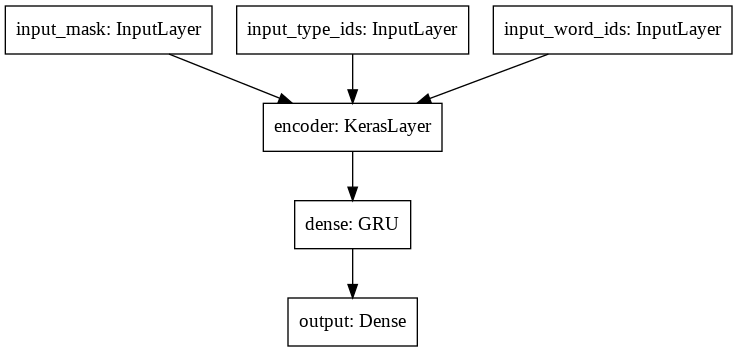

In [ ]:
tf.keras.utils.plot_model(test_classifier_model)


In [ ]:
# Setting configuration for model
def get_configuration():

  loss = loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),

  metric = tf.keras.metrics.SparseCategoricalAccuracy(
        'accuracy', dtype=tf.float32)

  return metric, loss

### Step 10: Fine-Tuning BERT for sentence pairs Classification
### Optimizor

For fine-tuning, let's use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as [`AdamW`](https://arxiv.org/abs/1711.05101).

For the learning rate (init_lr), we will use the same schedule as BERT pre-training: linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (num_warmup_steps). In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5). 

In [ ]:
## Instantiating the model
classifier_model = create_model()

optimizer = optimization.create_optimizer(
      init_lr=init_lr,
      num_train_steps=num_train_steps,
      num_warmup_steps=num_warmup_steps,
      optimizer_type='adamw')


In [ ]:
# Compiling the model
metric, loss = get_configuration()

classifier_model.compile(optimizer=optimizer,
              loss=loss,
              metrics = metric)
classifier_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
encoder (KerasLayer)            {'encoder_outputs':  109482241   input_mask[0][0]                 
                                                                 input_type_ids[0][0]       

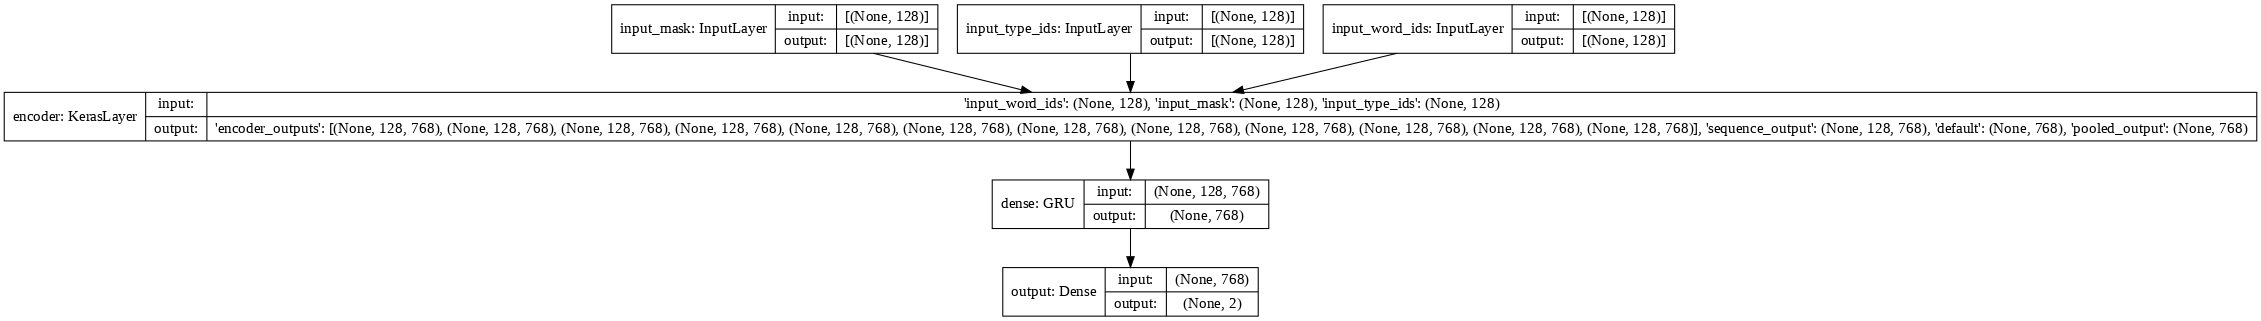

In [ ]:
tf.keras.utils.plot_model(model = classifier_model, show_shapes = True, dpi=76 )

In [ ]:
for text , labls in train_data.take(1):
  print(labls)

tf.Tensor([0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(32,), dtype=int64)


In [ ]:
# Training the model

validation_steps = no_of_valid_examples // batch_size
class_wgt = { 1:4.0, 0:1.0 }

history = classifier_model.fit(
      x=train_data,
      validation_data=valid_data,
      steps_per_epoch=steps_per_epoch,
      epochs=epochs,
      validation_steps=validation_steps,
      class_weight = class_wgt)

Epoch 1/4
26/26 [==============================] - 53s 1s/step - loss: 1.0378 - accuracy: 0.7019 - val_loss: 0.4495 - val_accuracy: 0.8646
Epoch 2/4
26/26 [==============================] - 37s 1s/step - loss: 0.9393 - accuracy: 0.8197 - val_loss: 0.6032 - val_accuracy: 0.7396
Epoch 3/4
26/26 [==============================] - 37s 1s/step - loss: 0.7744 - accuracy: 0.8462 - val_loss: 0.5017 - val_accuracy: 0.8125
Epoch 4/4
26/26 [==============================] - 37s 1s/step - loss: 0.7061 - accuracy: 0.8510 - val_loss: 0.4995 - val_accuracy: 0.7708


### Step 11: Evaluating Model performance visually

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

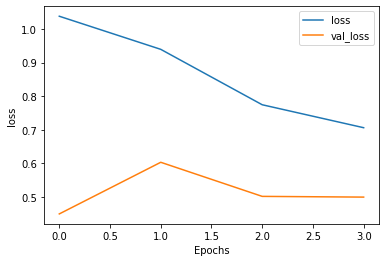

In [ ]:
plot_graphs(history,'loss')

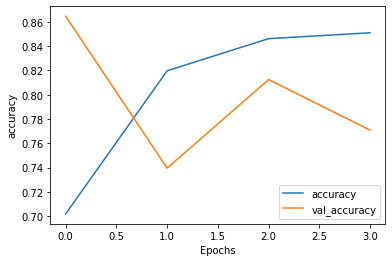

In [ ]:
plot_graphs(history,'accuracy')

### Step 12 : Exporting model for inference

In [ ]:
dataset_name = 'CRM/'
main_save_path = './my_models_BERT'

hub_bert_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"
bert_type = hub_bert_url.split('/')[-2]
saved_model_name = f'{dataset_name.replace("/", "_")}_{bert_type}'
print(hub_bert_url)
print(bert_type)
print(saved_model_name)

saved_model_path = os.path.join(main_save_path, saved_model_name)
print(saved_model_path)

https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4
bert_en_uncased_L-12_H-768_A-12
CRM__bert_en_uncased_L-12_H-768_A-12
./my_models_BERT/CRM__bert_en_uncased_L-12_H-768_A-12


In [ ]:
sentence_feature = str('Clean_text')
bert_preprocess_model = make_bert_preprocess_model(sentence_feature)
  
bert_preprocess_model.inputs

[<KerasTensor: shape=(None,) dtype=string (created by layer 'Clean_text')>]

In [ ]:
preprocess_inputs = bert_preprocess_model.inputs
print(preprocess_inputs)
bert_preprocess_model(preprocess_inputs)

[<KerasTensor: shape=(None,) dtype=string (created by layer 'Clean_text')>]


{'input_mask': <KerasTensor: shape=(None, 128) dtype=int32 (created by layer 'model_3')>,
 'input_type_ids': <KerasTensor: shape=(None, 128) dtype=int32 (created by layer 'model_3')>,
 'input_word_ids': <KerasTensor: shape=(None, 128) dtype=int32 (created by layer 'model_3')>}

In [ ]:
bert_encoder_inputs = bert_preprocess_model(preprocess_inputs)
classifier_model(bert_encoder_inputs)

<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'model_2')>

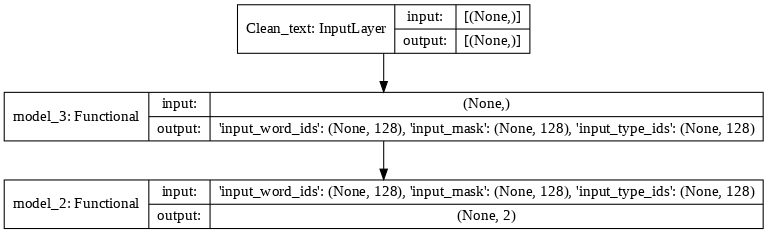

In [ ]:
# Merging both preprocessor and BERT model for inference
# As we can see in below plot the model can directly handle raw inputs and shows final results

bert_outputs = classifier_model(bert_encoder_inputs)
model_for_export = tf.keras.Model(preprocess_inputs, bert_outputs)
tf.keras.utils.plot_model(model = model_for_export, show_shapes = True, dpi=76 )

In [ ]:
%cd /content/gdrive/MyDrive/Colab DataSets/

/content/gdrive/MyDrive/Colab DataSets


In [ ]:
%ls

 abcnews-date-text.csv   data_lm.pkl                models/
 clean_data.pkl          deu.txt                    queries.txt
 Clean_encoded.txt       english-german.pkl        'sample_test[1].txt'
 CRM_updated_test.txt    english-german-test.pkl    socrates_sequences.txt
 CRM_updated_train.txt   english-german-train.pkl   socrates.txt
 CRM_updated.txt         fake_news_train.csv
 data_clas.pkl           model.png


In [ ]:
main_save_path = './my_models_BERT_2'
bert_type = hub_bert_url.split('/')[-2]
saved_model_name = f'{dataset_name.replace("/", "_")}_{bert_type}'

saved_model_path = os.path.join(main_save_path, saved_model_name)

preprocess_inputs = bert_preprocess_model.inputs
bert_encoder_inputs = bert_preprocess_model(preprocess_inputs)
bert_outputs = classifier_model(bert_encoder_inputs)
model_for_export = tf.keras.Model(preprocess_inputs, bert_outputs)

print('Saving', saved_model_path)

# Save everything on the Colab host (even the variables from GPU memory)
save_options = tf.saved_model.SaveOptions(experimental_io_device='')
model_for_export.save(saved_model_path, include_optimizer=False,
                      options=save_options)

Saving ./my_models_BERT/CRM__bert_en_uncased_L-12_H-768_A-12


### Step 13 : Testing our BERT Model

In [ ]:
reloaded_model = tf.saved_model.load(saved_model_path)


In [ ]:
test_text = ["prema share detail experience i tableau want demo saturday prema share detail seminar"]
actual_label = [1]

results = reloaded_model(test_text)
actual = np.argmax(tf.sigmoid(results))
print(" Model results :", results)
print(" Class :", actual)

 Model results : tf.Tensor([[ 0.09372946 -0.5627309 ]], shape=(1, 2), dtype=float32)
 Class : 0


In [ ]:
saved_model_path

'./my_models_BERT/CRM__bert_en_uncased_L-12_H-768_A-12'